In [1]:
import os
import json
import math
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

/tmp/ipykernel_24700/1663330791.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [5]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [6]:
DATASET_PATH = "/home/ahmed/work/autoEncoderWorks/data"
CHECKPOINT_PATH = "/home/ahmed/work/autoEncoderWorks/saved_models/tutorial9"

pl.seed_everything(42)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Global seed set to 42


Device: cuda:0


In [8]:
BATCH_SIZE=256
EPOCHS=5

In [9]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,))])

train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


In [10]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
 
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),
            nn.Flatten(), # Image grid to single feature vector
            nn.Linear(2*16*c_hid, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels : int,
                 base_channel_size : int,
                 latent_dim : int,
                 act_fn : object = nn.GELU):
 
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*16*c_hid),
            act_fn()
        )
        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 4x4 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), # 8x8 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2), # 16x16 => 32x32
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [12]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class : object = Encoder,
                 decoder_class : object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        # Saving hyperparameters of autoencoder
        self.save_hyperparameters()
        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        # Example input array needed for visualizing the graph of the network
        self.example_input_array = torch.zeros(2, num_input_channels, width, height)

    def forward(self, x):
       
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
       
        x, _ = batch # We do not need the labels
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1,2,3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)

In [13]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs 
        self.every_n_epochs = every_n_epochs 

    def on_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.no_grad():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()
            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1,1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

In [18]:
def train_cifar(latent_dim, use_pretrained = False):
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=EPOCHS,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch"), pl.callbacks.progress.TQDMProgressBar(refresh_rate=3)])
    trainer.logger._log_graph = True         
    trainer.logger._default_hp_metric = None 

    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename) and use_pretrained:
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
        trainer.fit(model, train_loader, val_loader)
    val_result = trainer.test(model, test_dataloaders=val_loader, verbose=False)
    test_result = trainer.test(model, test_dataloaders=test_loader, verbose=False)
    result = {"test": test_result, "val": val_result}
    return model, result

In [19]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_cifar(latent_dim, use_pretrained=False)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 168 K  | [2, 3, 32, 32] | [2, 64]       
1 | decoder | Decoder | 168 K  | [2, 64]        | [2, 3, 32, 32]
----------------------------------------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.348     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)
Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:906: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 233 K  | [2, 3, 32, 32] | [2, 128]      
1 | decoder | Decoder | 234 K  | [2, 128]       | [2, 3, 32, 32]
----------------------------------------------------------------------
468 K     Trainable params
0         Non-trainable params
468 K     Total params
1.873     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 364 K  | [2, 3, 32, 32] | [2, 256]      
1 | decoder | Decoder | 365 K  | [2, 256]       | [2, 3, 32, 32]
----------------------------------------------------------------------
730 K     Trainable params
0         Non-trainable params
730 K     Total params
2.922     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 496 K  | [2, 3, 32, 32] | [2, 384]      
1 | decoder | Decoder | 496 K  | [2, 384]       | [2, 3, 32, 32]
----------------------------------------------------------------------
992 K     Trainable params
0         Non-trainable params
992 K     Total params
3.971     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

In [22]:
plt.close()

[64, 128, 256, 384]
dict_keys([64, 128, 256, 384])


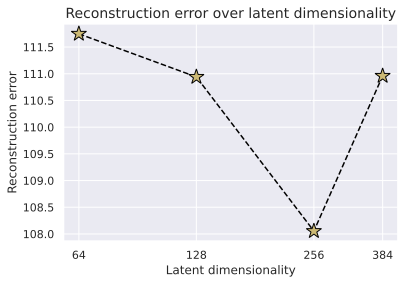

In [26]:
latent_dims = sorted([k for k in model_dict])
print(latent_dims)
print(model_dict.keys())
val_scores = [model_dict[k]["result"]["val"][0]["test_loss"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
#plt.ylim(0,100)
plt.show()

In [27]:
val_scores

[111.7480239868164, 110.94066619873047, 108.05308532714844, 110.95929718017578]

In [28]:
def visualize_reconstructions(model, input_imgs):
    # Reconstruct images
    model.eval()
    with torch.no_grad():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0,1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


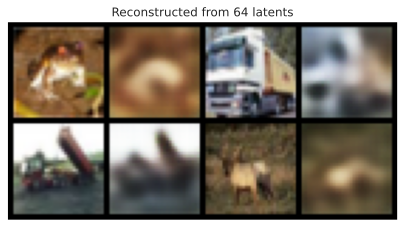

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


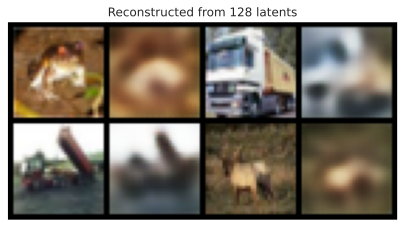

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


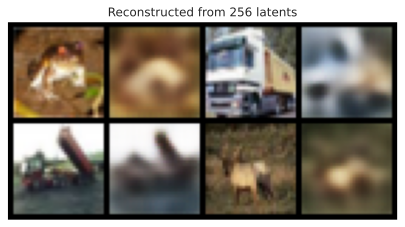

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


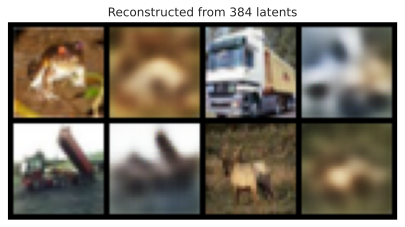

In [29]:
input_imgs = get_train_images(4)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["model"], input_imgs)

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


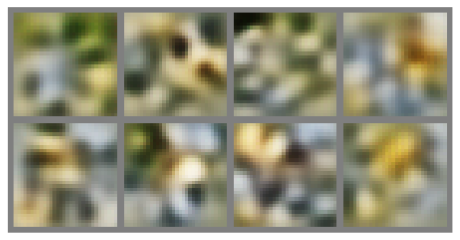

In [30]:
model = model_dict[256]["model"]
latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)
with torch.no_grad():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [31]:
model = model_dict[128]["model"]

In [32]:
model

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU()
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): GELU()
    )
    (net): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): GELU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [34]:
model.encoder

Encoder(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=128, bias=True)
  )
)

In [35]:
def embed_imgs(model, data_loader):
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds = embed_imgs(model, test_loader)

Encoding images:   0%|          | 0/175 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/40 [00:00<?, ?it/s]

In [36]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    dist = torch.cdist(query_z[None,:], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)
    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/torchvision/utils.py:50: UserWarning: range will be deprecated, please use value_range instead.
  warnings.warn(warning)


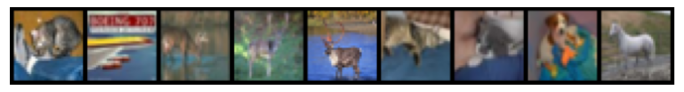

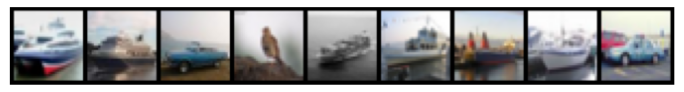

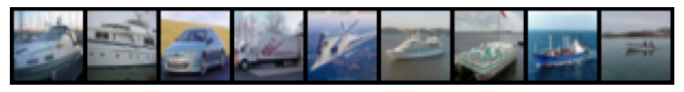

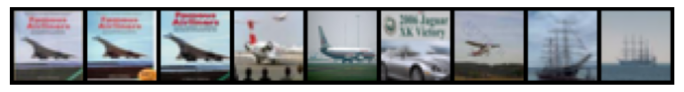

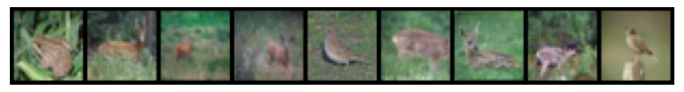

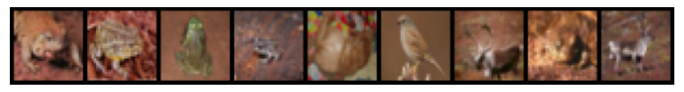

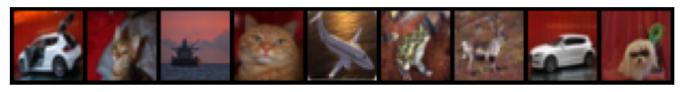

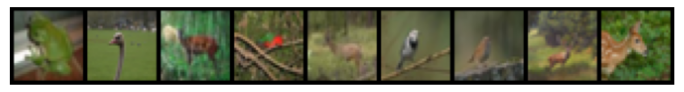

In [37]:
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

In [42]:
CHECKPOINT_PATH

'/home/ahmed/work/autoEncoderWorks/saved_models/tutorial9'

In [45]:
checkpoint = torch.load(CHECKPOINT_PATH+"/cifar10_128.ckpt")

In [47]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'hparams_name', 'hyper_parameters'])

In [52]:
checkpoint['state_dict'].keys()

odict_keys(['encoder.net.0.weight', 'encoder.net.0.bias', 'encoder.net.2.weight', 'encoder.net.2.bias', 'encoder.net.4.weight', 'encoder.net.4.bias', 'encoder.net.6.weight', 'encoder.net.6.bias', 'encoder.net.8.weight', 'encoder.net.8.bias', 'encoder.net.11.weight', 'encoder.net.11.bias', 'decoder.linear.0.weight', 'decoder.linear.0.bias', 'decoder.net.0.weight', 'decoder.net.0.bias', 'decoder.net.2.weight', 'decoder.net.2.bias', 'decoder.net.4.weight', 'decoder.net.4.bias', 'decoder.net.6.weight', 'decoder.net.6.bias', 'decoder.net.8.weight', 'decoder.net.8.bias'])

In [71]:
#checkpoint.items()

In [56]:
encoder = Encoder(num_input_channels=3, base_channel_size= 32, latent_dim= 128)

In [58]:
encoder.state_dict().keys()

odict_keys(['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.4.weight', 'net.4.bias', 'net.6.weight', 'net.6.bias', 'net.8.weight', 'net.8.bias', 'net.11.weight', 'net.11.bias'])

In [72]:
checkpoint_dict = {key: value for key,value in checkpoint["state_dict"].items() if "encoder."+key in encoder.state_dict()}
checkpoint_dict

{}

In [76]:
type(checkpoint["state_dict"])

collections.OrderedDict

In [79]:
checkpoint["state_dict"].keys()

odict_keys(['encoder.net.0.weight', 'encoder.net.0.bias', 'encoder.net.2.weight', 'encoder.net.2.bias', 'encoder.net.4.weight', 'encoder.net.4.bias', 'encoder.net.6.weight', 'encoder.net.6.bias', 'encoder.net.8.weight', 'encoder.net.8.bias', 'encoder.net.11.weight', 'encoder.net.11.bias', 'decoder.linear.0.weight', 'decoder.linear.0.bias', 'decoder.net.0.weight', 'decoder.net.0.bias', 'decoder.net.2.weight', 'decoder.net.2.bias', 'decoder.net.4.weight', 'decoder.net.4.bias', 'decoder.net.6.weight', 'decoder.net.6.bias', 'decoder.net.8.weight', 'decoder.net.8.bias'])

In [162]:
t = Autoencoder.load_from_checkpoint(CHECKPOINT_PATH+"/cifar10_128.ckpt")

In [163]:
t.eval()

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU()
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): GELU()
    )
    (net): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): GELU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [164]:
t.freeze()

In [165]:
t

Autoencoder(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU()
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (linear): Sequential(
      (0): Linear(in_features=128, out_features=1024, bias=True)
      (1): GELU()
    )
    (net): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): GELU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1),

In [150]:
t.state_dict().keys()

odict_keys(['encoder.net.0.weight', 'encoder.net.0.bias', 'encoder.net.2.weight', 'encoder.net.2.bias', 'encoder.net.4.weight', 'encoder.net.4.bias', 'encoder.net.6.weight', 'encoder.net.6.bias', 'encoder.net.8.weight', 'encoder.net.8.bias', 'encoder.net.11.weight', 'encoder.net.11.bias', 'decoder.linear.0.weight', 'decoder.linear.0.bias', 'decoder.net.0.weight', 'decoder.net.0.bias', 'decoder.net.2.weight', 'decoder.net.2.bias', 'decoder.net.4.weight', 'decoder.net.4.bias', 'decoder.net.6.weight', 'decoder.net.6.bias', 'decoder.net.8.weight', 'decoder.net.8.bias'])

In [87]:
k,v = next(iter(t.state_dict().items()))

In [88]:
k

'encoder.net.0.weight'

In [90]:
#v

In [94]:
import re
?re.sub

Signature: re.sub(pattern, repl, string, count=0, flags=0)
Docstring:
Return the string obtained by replacing the leftmost
non-overlapping occurrences of the pattern in string by the
replacement repl.  repl can be either a string or a callable;
if a string, backslash escapes in it are processed.  If it is
a callable, it's passed the Match object and must return
a replacement string to be used.
File:      ~/.pyenv/versions/3.9.1/lib/python3.9/re.py
Type:      function


In [93]:
'encoder.net.0.weight'.strip('encoder.')

't.0.weight'

In [95]:
re.sub(r"encoder\.","","encoder.net.0.weight")

'net.0.weight'

In [166]:
checkpoint_dict = {re.sub(r"encoder\.","",key): value for key,value in t.state_dict().items() if re.sub(r"encoder\.","",key) in encoder.state_dict()}
checkpoint_dict.keys()

dict_keys(['net.0.weight', 'net.0.bias', 'net.2.weight', 'net.2.bias', 'net.4.weight', 'net.4.bias', 'net.6.weight', 'net.6.bias', 'net.8.weight', 'net.8.bias', 'net.11.weight', 'net.11.bias'])

In [167]:
encoder.load_state_dict(checkpoint_dict, strict= False)

<All keys matched successfully>

In [168]:
!pip install torchmetrics

You should consider upgrading via the '/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/bin/python3.9 -m pip install --upgrade pip' command.


In [169]:
import torchmetrics

In [170]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.Linear(128, 64)
        self.L2 = nn.Linear(64, 32)
        self.L3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = F.relu(self.L1(x))
        x = F.relu(self.L2(x))
        x = F.log_softmax(self.L3(x), dim=1)
        return x

In [171]:
encoder

Encoder(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): GELU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): GELU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): GELU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): GELU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (9): GELU()
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1024, out_features=128, bias=True)
  )
)

In [172]:
class Classification(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.accuracy = torchmetrics.Accuracy()
        self.encoder = encoder
        self.classifier = Classifier()
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        preds = torch.argmax(logits, dim = 1)
        acc = self.accuracy(preds, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, logger=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        preds = torch.argmax(logits, dim = 1)
        acc = self.accuracy(preds, y)
        self.log("val_loss", loss, prog_bar= True)
        self.log("val_acc", acc, prog_bar= True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        preds = torch.argmax(logits, dim = 1)
        acc = self.accuracy(preds, y)
        self.log("test_loss", loss, prog_bar= True)
        self.log("test_acc", acc, prog_bar= True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode='min',
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "val_loss"}

In [108]:
encoder.state_dict()['net.2.weight'].shape

torch.Size([32, 32, 3, 3])

In [110]:
input_imgs.shape

torch.Size([4, 3, 32, 32])

In [115]:
with torch.no_grad():
    reconst_imgs = model(input_imgs.to(model.device))
reconst_imgs = reconst_imgs.cpu()
#model(input_imgs.to(device))

In [116]:
reconst_imgs.shape

torch.Size([4, 3, 32, 32])

In [117]:
with torch.no_grad():
    bottleneck = encoder(input_imgs.to(model.device))

In [118]:
bottleneck.shape

torch.Size([4, 128])

In [123]:
classFicationWithBottleneckModel = Classification()

In [124]:
classFicationWithBottleneckModel

Classification(
  (accuracy): Accuracy()
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): GELU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): GELU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): GELU()
      (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): GELU()
      (10): Flatten(start_dim=1, end_dim=-1)
      (11): Linear(in_features=1024, out_features=128, bias=True)
    )
  )
  (classifier): Classifier(
    (L1): Linear(in_features=128, out_features=64, bias=True)
    (L2): Linear(in_features=64, out_features=32, bias=True)
    (L3): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [130]:
classModel = Classifier()

In [131]:
classModel

Classifier(
  (L1): Linear(in_features=128, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=32, bias=True)
  (L3): Linear(in_features=32, out_features=10, bias=True)
)

In [132]:
with torch.no_grad():
    bottleneck = encoder(input_imgs.to(model.device))
    classes = classModel(bottleneck) 

In [174]:
classes

tensor([[-2.2756, -2.2105, -2.4003, -2.3530, -2.3496, -2.2175, -2.3347, -2.3042,
         -2.3998, -2.2059],
        [-2.2953, -2.2200, -2.4267, -2.3607, -2.3708, -2.1675, -2.3768, -2.3108,
         -2.3473, -2.1852],
        [-2.2878, -2.1680, -2.4120, -2.3325, -2.4241, -2.1946, -2.3953, -2.2731,
         -2.3435, -2.2318],
        [-2.2482, -2.1962, -2.3763, -2.3648, -2.3662, -2.2199, -2.3649, -2.3266,
         -2.3896, -2.2017]])

In [173]:
with torch.no_grad():
    #bottleneck = encoder(input_imgs.to(model.device))
    classes =  classFicationWithBottleneckModel(input_imgs.to(device))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [175]:
trainer = pl.Trainer()
trainer.fit(classFicationWithBottleneckModel, train_loader, val_loader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/ahmed/.pyenv/versions/3.9.1/envs/autoEncoder/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1584: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  rank_zero_warn(
Missing logger folder: /home/ahmed/work/autoEncoderWorks/lightning_logs

  | Name       | Type       | Params
------------------------------------------
0 | accuracy   | Accuracy   | 0     
1 | encoder    | Encoder    | 233 K 
2 | classifier | Classifier | 10.7 K
------------------------------------------
244 K     Trainable params
0         Non-trainable params
244 K     Total params
0.977     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/tmp/ipykernel_24700/1699570892.py:11: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(self.L3(x))


TypeError: nll_loss_nd(): argument 'input' (position 1) must be Tensor, not NoneType